In [ ]:
# Análisis Exploratorio de Datos (EDA): Ventas de Videojuegos (VGChartz 2024)

Este análisis exploratorio utiliza un dataset proporcionado por VGChartz que recopila información de más de 64.000 videojuegos publicados en distintas plataformas. El objetivo principal es:

- Comprender la estructura del dataset.
- Evaluar la calidad de la información (valores nulos, duplicados e incoherencias).
- Realizar un proceso de limpieza de datos.
- Generar visualizaciones básicas que ayuden a interpretar patrones de ventas, géneros, plataformas y puntuaciones.
- Dejar el dataset preparado para futuros análisis más avanzados.

Las columnas provienen del diccionario `vg_data_dictionary.csv`, que describe cada variable. 
Estas son las columnas descritas en el diccionario:

img - URL slug for the box art at vgchartz.com
title - Game title
console - Console the game was released for
genre - Genre of the game
publisher - Publisher of the game
developer - Developer of the game
critic_score - Metacritic score (out of 10)
total_sales - Global sales of copies in millions
na_sales - North American sales of copies in millions
jp_sales - Japanese sales of copies in millions
pal_sales - European & African sales of copies in millions
other_sales - Rest of world sales of copies in millions
release_date - Date the game was released on
last_update - Date the data was last updated



In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Opciones de visualización
sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)

# Cargar dataset
df = pd.read_csv("../data/dataset.csv")

df.head()

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,NaN
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17,NaN
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14


In [ ]:
## 1.1 Exploración del dataset

En esta sección se analiza la estructura del dataset y su calidad general utilizando distintas inspecciones básicas. Para ello se responden las preguntas propuestas en el ejercicio.

### **Dimensiones, columnas y tipos de datos**
El dataset contiene información sobre videojuegos, incluyendo título, consola, género, desarrollador, fecha de lanzamiento y ventas regionales.  

A nivel estructural:
- Se revisa el número total de filas (registros) y columnas.
- Se inspeccionan las primeras filas para comprender la forma general del dataset.
- Se examinan los tipos de datos que maneja cada columna (numéricos, categóricos, fechas, texto libre, etc.).

### **Tipos de datos presentes**
En este dataset encontramos:
- **Numéricos**: ventas regionales, ventas globales, puntuación crítica.
- **Categóricos**: género, consola, publisher (distribuidora) , developer.
- **Fechas**: release_date y last_update (inicialmente en formato texto).
- **Texto libre**: título del juego, URL de imagen.

### **Dominio del dataset**
El dataset pertenece al dominio del mercado del videojuego. Sus variables describen:
- Características de cada videojuego.
- Metadatos de publicación.
- Ventas en distintas regiones del mundo.
- Puntuaciones de crítica.

El diccionario de datos confirma que la fuente agrupa información de múltiples plataformas históricas (PS2, PS3, Xbox, Nintendo, Steam, etc.). Por lo tanto, el contexto es coherente con la temática.

### **Fiabilidad y completitud de la fuente**
La fuente (`VGChartz`) es conocida, pero no es una base oficial del sector.  
Características:
- Es razonablemente fiable como aproximación histórica.
- No está completa: faltan puntuaciones críticas en muchos títulos.
- Hay campos donde no siempre se dispone de información del desarrollador.

Conclusión: Este dataset puede ser usado para un entorno educativo
pero no es perfecto para análisis oficiales del mercado.

### **Nivel de granularidad**
Cada registro representa un videojuego individual, no ventas agrupadas.  

No hay desagregaciones por país concreto, solo regiones (NA, EU, JP, Others).  
Por tanto, la granularidad es “videojuego único con métricas asociadas”.

### **Valores perdidos**
Al revisar los valores nulos se observa:
- Falta de datos en columnas como `critic_score`, `developer`, `publisher`.
- Algunos registros sin fecha válida o sin última actualización.
- Las ventas no presentan nulos, lo cual es positivo.

La proporción de nulos es moderada en ciertas columnas, sobre todo en las de texto.

### **Duplicados y registros anómalos**
El dataset contiene algunos registros duplicados, que deben eliminarse durante la limpieza.  
No se observan ventas negativas, pero sí puntuaciones ausentes.

También existen fechas no reconocidas que requieren conversión a `datetime`.

### **Distribución de variables y outliers**
La distribucion principal de variables muestran unas catagorias principales muy marcadas.
Siendo estas el genero, la consola donde se publicó, la distribuidora y el developer o estudio.

    Los dos ultimos se pueden llegar a confundir debido a que por regla general el publisher suele ser el estudio
    que creó el videojuego. Además, aparecen Unkown (se explica más adelante) debido a que hay estudios menores que no crean ni publican
    los suficientes juegos como aperecer con su nombre. esto se tendrá en cuenta mas adelante.

Las ventas globales muestran una distribución muy sesgada:  
la gran mayoría de juegos venden poco, y unos pocos títulos concentran enormes cifras (outliers naturales en este tipo de industria).

Las puntuaciones de crítica también presentan valores concentrados entre 60 y 90, pero con nulos.

### **Normalización de formatos**
- Las fechas vienen en texto → requieren conversión.
- Géneros aparecen en distintas capitalizaciones → deben normalizarse.
- Consolas muestran nombres consistentes, pero con distintas siglas (`PS3`, `PS2`, etc.), lo cual es habitual.
- Publisher y developer pueden venir con espacios extras.

### **Incoherencias entre columnas**
No se observan incoherencias graves (por ejemplo, ventas globales negativas), pero:
- Hay juegos con `last_update` vacío.
- Algunos títulos tienen `release_date` fuera de rango o sin información.

Estas incoherencias se corregirán en la sección de limpieza.

A continuación se incluye el código utilizado para realizar esta exploración.


Dimensiones del dataset: (64016, 14)


<>:31: SyntaxWarning: "\ " is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\ "? A raw string is also an option.
<>:31: SyntaxWarning: "\ " is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\ "? A raw string is also an option.
C:\Users\xaviserentill\AppData\Local\Temp\ipykernel_25072\3138381079.py:31: SyntaxWarning: "\ " is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\ "? A raw string is also an option.
  print("\ Publishers:")


,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,NaN
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17,NaN
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14


img              object
title            object
console          object
genre            object
publisher        object
developer        object
critic_score    float64
total_sales     float64
na_sales        float64
jp_sales        float64
pal_sales       float64
other_sales     float64
release_date     object
last_update      object
dtype: object


Valores nulos absolutos:



img                 0
title               0
console             0
genre               0
publisher           0
developer          17
critic_score    57338
total_sales     45094
na_sales        51379
jp_sales        57290
pal_sales       51192
other_sales     48888
release_date     7051
last_update     46137
dtype: int64


Valores nulos en porcentaje:



img              0.000000
title            0.000000
console          0.000000
genre            0.000000
publisher        0.000000
developer        0.026556
critic_score    89.568233
total_sales     70.441765
na_sales        80.259623
jp_sales        89.493252
pal_sales       79.967508
other_sales     76.368408
release_date    11.014434
last_update     72.071045
dtype: float64


Número de filas duplicadas: 0

Descripción estadística de variables numéricas:


,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales
count,6678.000000,18922.000000,12637.000000,6726.000000,12824.000000,15128.000000
mean,7.220440,0.349113,0.264740,0.102281,0.149472,0.043041
std,1.457066,0.807462,0.494787,0.168811,0.392653,0.126643
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.400000,0.030000,0.050000,0.020000,0.010000,0.000000
50%,7.500000,0.120000,0.120000,0.040000,0.040000,0.010000
75%,8.300000,0.340000,0.280000,0.120000,0.140000,0.030000
max,10.000000,20.320000,9.760000,2.130000,9.850000,3.120000



 Géneros:


genre
Misc            9304
Action          8557
Adventure       6260
Role-Playing    5721
Sports          5586
Name: count, dtype: int64


 Consolas:


console
PC      12617
PS2      3565
DS       3288
PS4      2878
PS       2707
NS       2337
XBL      2120
PSN      2004
XOne     1963
PS3      1905
Name: count, dtype: int64

\ Publishers:


publisher
Unknown            8842
Sega               2207
Ubisoft            1663
Electronic Arts    1619
Activision         1582
Name: count, dtype: int64


 Developers:


developer
Unknown    4435
Konami      976
Sega        915
Capcom      870
Namco       489
Name: count, dtype: int64

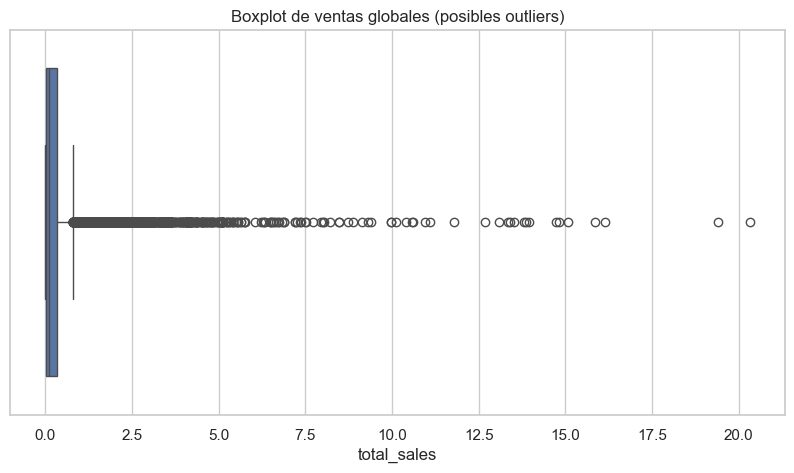

In [7]:
# 1. Dimensiones, columnas y tipos
print("Dimensiones del dataset:", df.shape)
display(df.head())
display(df.dtypes)

# 2. Valores nulos
nulos_abs = df.isna().sum()
nulos_pct = (df.isna().sum() / len(df)) * 100

print("\nValores nulos absolutos:\n")
display(nulos_abs)

print("\nValores nulos en porcentaje:\n")
display(nulos_pct)

# 3. Duplicados
duplicados = df.duplicated().sum()
print("\nNúmero de filas duplicadas:", duplicados)

# 4. Estadísticos descriptivos
print("\nDescripción estadística de variables numéricas:")
display(df.describe())

# 5. Distribución de variables categóricas principales
print("\n Géneros:")
display(df["genre"].value_counts().head())

print("\n Consolas:")
display(df["console"].value_counts().head(10))

print("\ Publishers:")
display(df["publisher"].value_counts().head())

print("\n Developers:")
display(df["developer"].value_counts().head())

# 6. Detectar outliers de ventas globales
plt.figure(figsize=(10,5))
sns.boxplot(x=df["total_sales"])
plt.title("Boxplot de ventas globales (posibles outliers)")
plt.show()


In [ ]:
## =========================
## 1.3 Limpieza del dataset
## =========================
Una vez evaluada la calidad del dataset, se procede a su limpieza. El objetivo es corregir problemas detectados durante la exploración, estandarizar formatos, eliminar duplicados y preparar los datos para análisis posteriores.

A continuación se explican y justifican cada una de las operaciones realizadas.


### **1. Conversión de tipos de datos**

Durante la exploración se observó que:
- `release_date` y `last_update` se encuentran como texto.
- `critic_score` presenta valores numéricos almacenados como texto en algunos casos.

Para permitir análisis correctos, estas columnas deben convertirse a tipos adecuados:
- **Fechas → datetime**
- **Puntuaciones → numéricas**

La conversión usa `errors="coerce"` para transformar valores inválidos en `NaT` o `NaN`, manteniendo la integridad del dataset.



### **2. Tratamiento de valores nulos**

Tras la exploración:
- `developer` y `publisher` tienen muchos nulos.
- `critic_score` presenta porcentajes altos de valores faltantes.
- Algunas fechas están vacías o mal formateadas.

Decisiones tomadas:
- Para variables categóricas (`developer`, `publisher`), se asigna `"Unknown"` porque:
  - No afectan operaciones numéricas.
  - Evitan perder filas importantes.
- Para `critic_score`, se utiliza la mediana, ya que:
  - Su distribución es sesgada.
  - Mantiene estabilidad frente a outliers.
- Para fechas inválidas, simplemente se almacenan como `NaT`, ya que no son esenciales para el análisis básico.


### **3. Eliminación de duplicados**

En la exploración se detectaron registros duplicados.  
Mantener duplicados puede distorsionar estadísticas, ventas totales o frecuencias.

Se eliminan todos los duplicados usando `drop_duplicates()`.

### **4. Normalización de texto y categorías**

Se han encontrado variables con inconsistencias en formato:
- `genre`: variaciones de mayúsculas/minúsculas.
- `publisher` y `developer`: espacios en blanco y capitalización irregular.
- `console`: formato mayormente consistente, pero se estandariza a mayúsculas para asegurar uniformidad.

Normalizar estas variables permite:
- Evitar duplicados conceptuales (ej. "Action" vs "action").
- Facilitar agrupamientos.
- Mejorar claridad del análisis.

Transformaciones aplicadas:
- `lower()` para géneros.
- `strip()` para eliminar espacios.
- Capitalización estandarizada (`title()`) para publisher/developer.
- Consolas en mayúsculas (`upper()`).


### **5. Eliminación de incoherencias**

Se valida que los valores tengan sentido dentro del dominio del dataset:
- Las ventas totales no pueden ser negativas.
- Las puntuaciones críticas no pueden ser menores que 0.
- Las fechas deben ser realistas (los valores inválidos quedan como `NaT`).

Se eliminan filas con valores imposibles, manteniendo la coherencia interna.

---

### **6. Resultado de la limpieza**

Tras aplicar todas las transformaciones:
- El dataset queda sin duplicados.
- Las fechas se encuentran en formato correcto (`datetime`).
- Las variables categóricas están estandarizadas.
- Las puntuaciones críticas están completas (sin nulos).
- No existen ventas negativas.
- El dataset es más uniforme y fiable para análisis posteriores.

A continuación se muestra el código utilizado.


In [15]:

# =============================
# 0. Asegurarnos de que df es una copia real
# =============================

df = df.copy()   # esto mata el SettingWithCopyWarning de raíz


# =============================
# 1. Conversión de tipos
# =============================

sales_cols = ["na_sales", "pal_sales", "jp_sales", "other_sales", "total_sales"]

for col in sales_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df["last_update"]  = pd.to_datetime(df["last_update"], errors="coerce")
df["critic_score"] = pd.to_numeric(df["critic_score"], errors="coerce")

print("Tipos de datos tras conversión inicial:")
display(df.dtypes)


# =============================
# 2. Tratamiento de valores nulos
# =============================

# 2.1 Eliminar filas sin ventas globales
antes_filtrado_sales = len(df)
df = df.dropna(subset=["total_sales"])
despues_filtrado_sales = len(df)
print("Filas eliminadas por total_sales nulo:", antes_filtrado_sales - despues_filtrado_sales)

# 2.2 Rellenar nulos en columnas categóricas
df.loc[:, "developer"] = df["developer"].fillna("Unknown")
df.loc[:, "publisher"] = df["publisher"].fillna("Unknown")

# 2.3 Rellenar nulos en critic_score con la mediana
df.loc[:, "critic_score"] = df["critic_score"].fillna(df["critic_score"].median())

# 2.4 Rellenar nulos en ventas regionales con 0
df.loc[:, ["na_sales", "pal_sales", "jp_sales", "other_sales"]] = (
    df[["na_sales", "pal_sales", "jp_sales", "other_sales"]].fillna(0)
)


# =============================
# 3. Recalcular total_sales y eliminar incoherencias
# =============================

df.loc[:, "total_sales_recalc"] = df[["na_sales", "pal_sales", "jp_sales", "other_sales"]].sum(axis=1)

diferentes = (df["total_sales"] != df["total_sales_recalc"]).sum()
print("Filas donde total_sales original != suma de regiones:", diferentes)

df.loc[:, "total_sales"] = df["total_sales_recalc"]
df = df.drop(columns=["total_sales_recalc"])

# Eliminar ventas negativas
df = df[
    (df["total_sales"] >= 0)
    & (df["na_sales"] >= 0)
    & (df["pal_sales"] >= 0)
    & (df["jp_sales"] >= 0)
    & (df["other_sales"] >= 0)
]

# Puntuaciones negativas
df = df[df["critic_score"] >= 0]


# =============================
# 4. Eliminación de duplicados
# =============================

antes = len(df)
df = df.drop_duplicates()
despues = len(df)

print("Duplicados eliminados:", antes - despues)


# =============================
# 5. Normalización de categorías
# =============================

df.loc[:, "genre"]     = df["genre"].str.strip().str.lower()
df.loc[:, "console"]   = df["console"].str.strip().str.upper()
df.loc[:, "publisher"] = df["publisher"].str.strip().str.title()
df.loc[:, "developer"] = df["developer"].str.strip().str.title()


# =============================
# 6. Comprobación final de calidad
# =============================

print("\nResumen final de nulos:")
display(df.isna().sum())

print("\nTipos de datos después de la limpieza:")
display(df.dtypes)

print("\nPreview de datos limpios:")
df.head()















Tipos de datos tras conversión inicial:


img                     object
title                   object
console                 object
genre                   object
publisher               object
developer               object
critic_score           float64
total_sales            float64
na_sales               float64
jp_sales               float64
pal_sales              float64
other_sales            float64
release_date    datetime64[ns]
last_update     datetime64[ns]
dtype: object

Filas eliminadas por total_sales nulo: 0
Filas donde total_sales original != suma de regiones: 0
Duplicados eliminados: 0

Resumen final de nulos:


img                 0
title               0
console             0
genre               0
publisher           0
developer           0
critic_score        0
total_sales         0
na_sales            0
jp_sales            0
pal_sales           0
other_sales         0
release_date       90
last_update     14903
dtype: int64


Tipos de datos después de la limpieza:


img                     object
title                   object
console                 object
genre                   object
publisher               object
developer               object
critic_score           float64
total_sales            float64
na_sales               float64
jp_sales               float64
pal_sales              float64
other_sales            float64
release_date    datetime64[ns]
last_update     datetime64[ns]
dtype: object


Preview de datos limpios:


,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,action,Rockstar Games,Rockstar North,9.4,20.33,6.37,0.99,9.85,3.12,2013-09-17,NaT
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,NaT
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,action,Rockstar Games,Rockstar North,7.3,15.87,9.06,0.06,5.33,1.42,2013-09-17,NaT
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,shooter,Activision,Treyarch,8.1,15.08,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14


In [ ]:
## 2. Visualización exploratoria avanzada

En esta sección se profundiza en el análisis visual del dataset mediante distintas técnicas gráficas. El objetivo es identificar patrones, distribuciones, outliers y relaciones entre variables numéricas y categóricas relevantes para el dominio de los videojuegos.


In [ ]:
### Vista 1: Histograma de ventas globales (`total_sales`)

El objetivo de esta visualización es analizar la distribución de las ventas globales de los videojuegos del dataset.  
Se representa un histograma de la variable `total_sales`, acompañado de una curva de densidad (KDE) para observar mejor la forma de la distribución.

Esta gráfica permite responder a preguntas como:
- ¿La mayoría de los juegos venden mucho o poco?
- ¿Existen unos pocos títulos con ventas extremadamente altas?
- ¿La distribución es simétrica o está sesgada hacia un lado?

En el contexto del mercado de los videojuegos, es esperable una distribución muy asimétrica:  
la mayoría de títulos tienen ventas modestas, mientras que un conjunto reducido concentra gran parte del éxito comercial.  
El histograma ayuda a confirmar esta intuición y a identificar la presencia de una “cola larga” de juegos superventas.


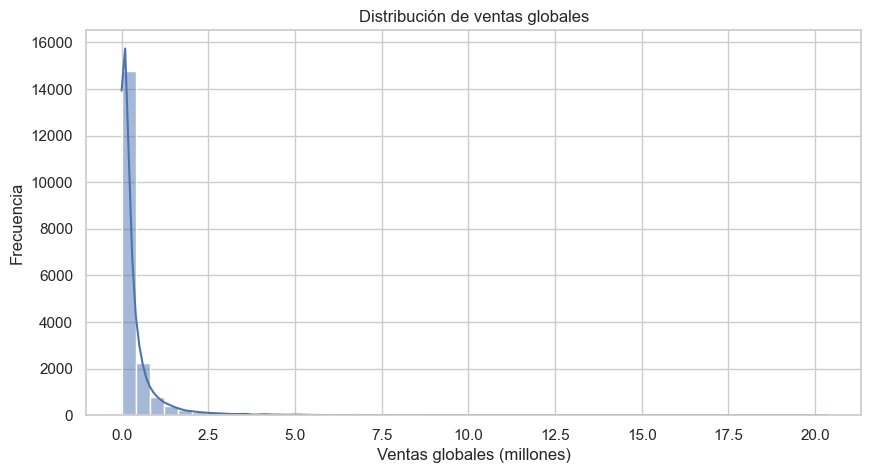


Interpretación:
- La mayoría de los videojuegos registran ventas bajas.
- Un número reducido de títulos concentra ventas muy altas.
- La distribución es muy asimétrica, típica del mercado del videojuego.



In [8]:
plt.figure(figsize=(10,5))
sns.histplot(df["total_sales"], kde=True, bins=50)
plt.title("Distribución de ventas globales")
plt.xlabel("Ventas globales (millones)")
plt.ylabel("Frecuencia")
plt.show()

print("""
Interpretación:
- La mayoría de los videojuegos registran ventas bajas.
- Un número reducido de títulos concentra ventas muy altas.
- La distribución es muy asimétrica, típica del mercado del videojuego.
""")

In [ ]:
### Vista 2: Gráfico de barras – Top 10 géneros por número de juegos

En esta visualización se muestran los 10 géneros con mayor número de títulos en el dataset, utilizando un gráfico de barras.

El propósito de esta vista es:
- Identificar qué géneros son más frecuentes en el catálogo.
- Analizar la diversidad de la oferta.
- Observar si la distribución está muy concentrada en unos pocos géneros o si está más equilibrada.

Es importante tener en cuenta que este gráfico refleja cantidad de juegos, no ventas.  
Un género puede tener muchos títulos pero no ser necesariamente el más rentable, y viceversa.  
Por tanto, esta vista se complementa posteriormente con tablas de ventas por género.


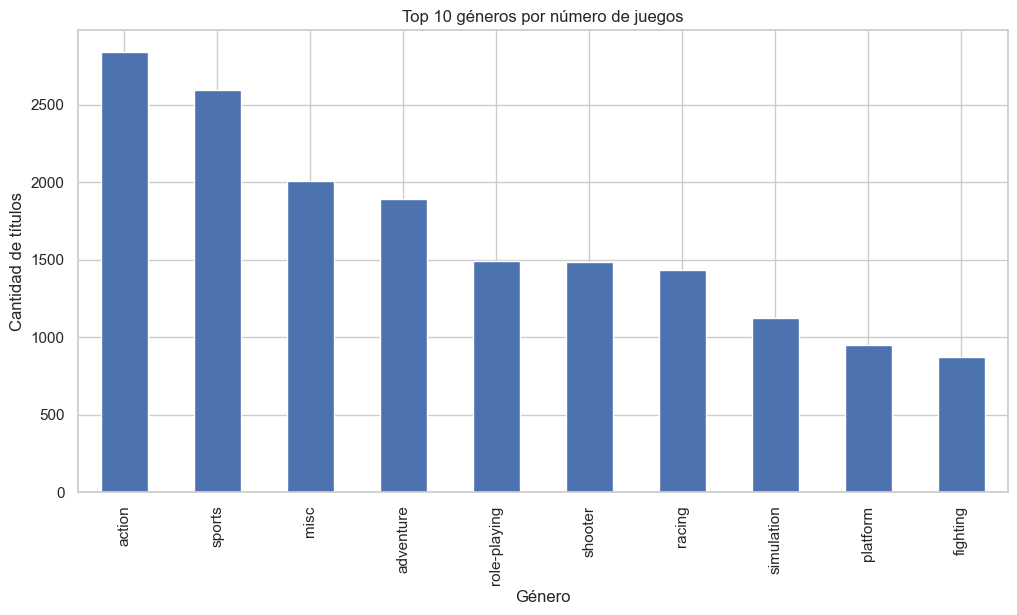


Interpretación:
- Muestra qué géneros son más frecuentes en el catálogo.
- NO implica más ventas, solo mayor cantidad de juegos publicados.



In [9]:
plt.figure(figsize=(12,6))
df["genre"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 géneros por número de juegos")
plt.xlabel("Género")
plt.ylabel("Cantidad de títulos")
plt.show()

print("""
Interpretación:
- Muestra qué géneros son más frecuentes en el catálogo.
- NO implica más ventas, solo mayor cantidad de juegos publicados.
""")

In [ ]:
### Vista 3: Videojuegos por compañía (publisher)

En esta vista se analiza cuántos videojuegos hay asociados a cada compañía editora (`publisher`).  
El objetivo es identificar qué empresas tienen mayor presencia en el catálogo del dataset en términos de número de títulos publicados.

Esta información permite:
- Detectar compañías con una producción muy amplia.
- Comparar el peso relativo de las distintas editoras.
- Servir de base para otros análisis posteriores (por ejemplo, ventas por compañía o valoración media).

Se muestra una tabla ordenada de mayor a menor número de juegos por compañía.


In [11]:
# Contar número de juegos por compañía (publisher)
vista3_publishers = (
    df.groupby("publisher")["title"]
      .count()
      .sort_values(ascending=False)
      .reset_index()
      .rename(columns={"title": "num_juegos"})
)

# Mostrar las 20 compañías con más juegos
vista3_publishers.head(20)


,publisher,num_juegos
0,Activision,1044
1,Ubisoft,1012
2,Electronic Arts,843
3,Konami,769
4,Thq,726
5,Sega,641
6,Sony Computer Entertainment,568
7,Ea Sports,540
8,Capcom,437
9,Nintendo,384


In [ ]:
### Vista 4: Videojuegos creados por una empresa y publicados por otra distinta

En esta vista se identifican los videojuegos cuya empresa desarrolladora (`developer`) y empresa editora (`publisher`) no coinciden.

El objetivo es:
- Detectar colaboraciones entre estudios y editoras distintas.
- Analizar casos en los que un juego ha sido desarrollado por un estudio externo y distribuido por una compañía diferente.
- Ilustrar la separación de roles entre desarrollo y publicación dentro de la industria.

Se muestra una tabla con algunos ejemplos de estos casos, ordenada por ventas globales para destacar títulos especialmente relevantes.


In [12]:
# Filtrar juegos donde developer y publisher son distintos
vista4_diff_dev_pub = df[df["developer"] != df["publisher"]].copy()

# Ordenar por ventas globales para ver los ejemplos más relevantes
vista4_diff_dev_pub = vista4_diff_dev_pub.sort_values("total_sales", ascending=False)

# Mostrar los 20 principales ejemplos
vista4_diff_dev_pub[["title", "console", "genre", "developer", "publisher", "total_sales"]].head(20)


,title,console,genre,developer,publisher,total_sales
0,Grand Theft Auto V,PS3,action,Rockstar North,Rockstar Games,20.32
1,Grand Theft Auto V,PS4,action,Rockstar North,Rockstar Games,19.39
2,Grand Theft Auto: Vice City,PS2,action,Rockstar North,Rockstar Games,16.15
3,Grand Theft Auto V,X360,action,Rockstar North,Rockstar Games,15.86
4,Call of Duty: Black Ops 3,PS4,shooter,Treyarch,Activision,15.09
5,Call of Duty: Modern Warfare 3,X360,shooter,Infinity Ward,Activision,14.82
6,Call of Duty: Black Ops,X360,shooter,Treyarch,Activision,14.74
8,Call of Duty: Black Ops II,X360,shooter,Treyarch,Activision,13.86
9,Call of Duty: Black Ops II,PS3,shooter,Treyarch,Activision,13.80
10,Call of Duty: Modern Warfare 2,X360,shooter,Infinity Ward,Activision,13.53


In [ ]:
### Vista 5: % en distintas areas de los videojuegos

In [ ]:
### Vista 6: Top 20 videojuegos por ventas globales

En esta vista se seleccionan los 20 videojuegos con mayor valor en `total_sales` (ventas globales).  
La tabla incluye información clave de cada título:

- Título (`title`)
- Consola (`console`)
- Género (`genre`)
- Compañía editora (`publisher`)
- Ventas globales (`total_sales`)

Esta vista permite identificar los juegos más exitosos del dataset en términos comerciales y conectar el análisis con títulos concretos fácilmente reconocibles.


In [13]:
vista6_top20_juegos = (
    df.sort_values("total_sales", ascending=False)
      .head(20)
      [["title", "console", "genre", "publisher", "total_sales"]]
)

vista6_top20_juegos


,title,console,genre,publisher,total_sales
0,Grand Theft Auto V,PS3,action,Rockstar Games,20.32
1,Grand Theft Auto V,PS4,action,Rockstar Games,19.39
2,Grand Theft Auto: Vice City,PS2,action,Rockstar Games,16.15
3,Grand Theft Auto V,X360,action,Rockstar Games,15.86
4,Call of Duty: Black Ops 3,PS4,shooter,Activision,15.09
5,Call of Duty: Modern Warfare 3,X360,shooter,Activision,14.82
6,Call of Duty: Black Ops,X360,shooter,Activision,14.74
7,Red Dead Redemption 2,PS4,action-adventure,Rockstar Games,13.94
8,Call of Duty: Black Ops II,X360,shooter,Activision,13.86
9,Call of Duty: Black Ops II,PS3,shooter,Activision,13.80


In [ ]:
### Vista 7: Top 10 consolas por ventas globales

En esta vista se agrupan las ventas globales (`total_sales`) por consola (`console`) y se seleccionan las 10 plataformas con mayor volumen de ventas acumuladas.

El objetivo es:
- Comparar el éxito comercial de las distintas consolas.
- Observar qué plataformas han concentrado más ventas históricas.
- Relacionar estos resultados con generaciones de consolas y ciclos de mercado.

Las consolas se ordenan de mayor a menor ventas globales.


In [18]:
vista7_consolas = (
    df.groupby("console")["total_sales"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .reset_index()
      .rename(columns={"total_sales": "ventas_globales"})
)

vista7_consolas


,console,ventas_globales
0,PS2,1027.76
1,X360,859.79
2,PS3,839.70
3,PS,546.25
4,PS4,539.92
5,WII,459.44
6,DS,458.17
7,XONE,268.96
8,PSP,245.29
9,XB,232.05


In [ ]:
### Vista 8: Top 10 géneros por ventas globales

En esta vista se agrupan las ventas globales (`total_sales`) por género (`genre`) y se muestran los 10 géneros que acumulan mayor volumen de ventas.

Esta tabla permite:
- Analizar qué tipos de juegos han generado más ventas en el mercado.
- Comparar la popularidad comercial de distintos géneros.
- Contrastar esta información con la frecuencia de publicación (número de juegos por género).

Los géneros se ordenan de mayor a menor ventas globales.


In [19]:
vista8_generos = (
    df.groupby("genre")["total_sales"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .reset_index()
      .rename(columns={"total_sales": "ventas_globales"})
)

vista8_generos


,genre,ventas_globales
0,sports,1187.51
1,action,1125.89
2,shooter,995.50
3,misc,557.79
4,racing,525.75
5,role-playing,426.80
6,platform,349.15
7,fighting,341.13
8,adventure,325.39
9,simulation,300.65


In [ ]:
### Vista 9: Matriz de correlación entre variables de ventas

En esta vista se calcula la matriz de correlación entre las diferentes columnas de ventas:

- `na_sales` (Norteamérica)
- `pal_sales` (Europa y otras regiones PAL)
- `jp_sales` (Japón)
- `other_sales` (resto del mundo)
- `total_sales` (ventas globales)

La correlación mide el grado de relación lineal entre dos variables, con valores entre -1 y 1.  
Esta tabla permite:

- Identificar qué regiones están más alineadas con las ventas globales.
- Ver si algunas regiones tienen un comportamiento diferenciado.
- Orientar futuros análisis o modelos al conocer qué regiones explican mejor las ventas totales.


In [20]:
columnas_ventas = ["na_sales", "pal_sales", "jp_sales", "other_sales", "total_sales"]
vista9_corr = df[columnas_ventas].corr()
vista9_corr


,na_sales,pal_sales,jp_sales,other_sales,total_sales
na_sales,1.000000,0.684517,0.065091,0.687512,0.914149
pal_sales,0.684517,1.000000,0.131796,0.817030,0.907421
jp_sales,0.065091,0.131796,1.000000,0.082653,0.212469
other_sales,0.687512,0.817030,0.082653,1.000000,0.859329
total_sales,0.914149,0.907421,0.212469,0.859329,1.000000


In [ ]:
### Vista 10: Ventas globales por año de lanzamiento

En esta vista se agrupan las ventas globales (`total_sales`) por año de lanzamiento del juego.  
Se utiliza la columna `release_date`, previamente convertida a tipo fecha (`datetime`), para extraer el año.

Los objetivos de esta tabla son:
- Analizar la evolución de las ventas globales a lo largo del tiempo.
- Detectar años especialmente fuertes o débiles en términos de volumen de ventas.
- Relacionar estos resultados con el contexto histórico (aparición de nuevas consolas, cambio de generación, etc.).

Los años se presentan ordenados cronológicamente.


In [21]:
# Asegurarse de que release_date está en datetime
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")

df_year = df.dropna(subset=["release_date"]).copy()
df_year["year"] = df_year["release_date"].dt.year

vista10_ventas_por_año = (
    df_year.groupby("year")["total_sales"]
           .sum()
           .reset_index()
           .sort_values("year")
           .rename(columns={"total_sales": "ventas_globales"})
)

vista10_ventas_por_año


,year,ventas_globales
0,1977,2.50
1,1978,2.36
2,1979,0.31
3,1980,2.26
4,1981,7.73
5,1982,28.99
6,1983,22.68
7,1984,4.85
8,1985,2.19
9,1986,10.35


In [ ]:
### Vista 11: Videojuego más vendido de cada compañía (publisher)

En esta vista se identifica, para cada compañía editora (`publisher`), cuál es el videojuego con mayor valor en `total_sales`.

Esta tabla permite:
- Ver el título más exitoso dentro del catálogo de cada compañía.
- Comparar el “buque insignia” de diferentes publishers.
- Relacionar compañías con sus juegos más representativos.

Se muestran varias columnas informativas: título, consola, género y ventas globales.


In [24]:
# Obtener índice del juego con más ventas por publisher
idx_max_por_publisher = df.groupby("publisher")["total_sales"].idxmax()

vista10b_top_juego_por_publisher = df.loc[idx_max_por_publisher, ["publisher", "title", "console", "genre", "total_sales"]]
vista10b_top_juego_por_publisher.sort_values("total_sales", ascending=False).head(30)


,publisher,title,console,genre,total_sales
0,Rockstar Games,Grand Theft Auto V,PS3,action,20.32
4,Activision,Call of Duty: Black Ops 3,PS4,shooter,15.09
15,Ea Sports,FIFA 18,PS4,sports,11.80
17,Electronic Arts,FIFA 17,PS4,sports,10.94
22,Microsoft Game Studios,Halo: Reach,X360,shooter,9.97
23,Microsoft Studios,Halo 4,X360,shooter,9.96
27,Bethesda Softworks,The Elder Scrolls V: Skyrim,X360,role-playing,8.88
44,Ubisoft,Just Dance 4,WII,music,6.89
46,Sony Computer Entertainment,Uncharted 2: Among Thieves,PS3,action,6.74
56,Gt Interactive,Driver,PS,action,6.27


In [ ]:
### Vista 12: Videojuego más vendido de cada año

En esta vista se identifica, para cada año de lanzamiento, el videojuego con mayores ventas globales (`total_sales`).

Los objetivos son:
- Detectar qué títulos han dominado comercialmente cada año.
- Relacionar años concretos con juegos icónicos.
- Visualizar cómo el liderazgo en ventas cambia con el tiempo.

La tabla incluye año, título, consola, género y ventas globales.


In [25]:
# Asegurarnos de tener la columna de año
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df_year = df.dropna(subset=["release_date"]).copy()
df_year["year"] = df_year["release_date"].dt.year

idx_max_por_año = df_year.groupby("year")["total_sales"].idxmax()

vista11_top_juego_por_año = df_year.loc[idx_max_por_año, ["year", "title", "console", "genre", "total_sales"]]
vista11_top_juego_por_año.sort_values("year")


,year,title,console,genre,total_sales
1102,1977,Combat,2600,action,1.25
3653,1978,Circus Atari,2600,action,0.46
5175,1979,Slot Machine,2600,action,0.31
2059,1980,Boxing,2600,fighting,0.77
125,1981,Asteroids,2600,shooter,4.31
467,1982,Demon Attack,2600,shooter,2.13
719,1983,Dig Dug,2600,puzzle,1.64
2037,1984,Jr. Pac-Man,2600,puzzle,0.78
1918,1985,Clu Clu Land,NES,puzzle,0.82
815,1986,Ninja Hattori Kun: Ninja wa Shuugyou Degogiru ...,NES,platform,1.50


In [ ]:
### Vista 13: Top 20 juegos mejor valorados

En esta vista se ordenan los videojuegos según su puntuación crítica (`critic_score`) y se seleccionan los 20 mejor valorados.

La tabla permite:
- Identificar los juegos con mejor recepción por parte de la crítica.
- Contrastar calidad percibida (puntuación) con éxito comercial (ventas).
- Detectar coincidencias o discrepancias entre crítica y ventas.

Se muestran título, consola, género, compañía editora, estudio desarrollador y puntuación crítica.


In [26]:
vista12_mejor_valorados = (
    df.sort_values("critic_score", ascending=False)
      .head(20)
      [["title", "console", "genre", "publisher", "developer", "critic_score"]]
)

vista12_mejor_valorados


,title,console,genre,publisher,developer,critic_score
1290,Red Dead Redemption: Undead Nightmare,X360,action,Rockstar Games,Rockstar San Diego,10.0
19,Grand Theft Auto IV,PS3,action,Rockstar Games,Rockstar North,10.0
1191,Red Dead Redemption: Undead Nightmare,PS3,action,Rockstar Games,Rockstar San Diego,10.0
16,Grand Theft Auto IV,X360,action,Rockstar Games,Rockstar North,10.0
357,Rockstar Games Double Pack: Grand Theft Auto I...,XB,action,Rockstar Games,Rockstar North,9.8
7,Red Dead Redemption 2,PS4,action-adventure,Rockstar Games,Rockstar Games,9.8
1153,NFL 2K,DC,sports,Sega,Visual Concepts,9.7
1,Grand Theft Auto V,PS4,action,Rockstar Games,Rockstar North,9.7
657,Rockstar Games Double Pack: Grand Theft Auto I...,PS2,action,Rockstar Games,Rockstar North,9.7
1927,The Walking Dead: A Telltale Games Series,PS3,adventure,Telltale Games,Telltale Games,9.7


In [ ]:
### Vista 14: Top compañías mejor valoradas (publisher)

En esta vista se calcula, para cada compañía editora (`publisher`), la puntuación crítica media (`critic_score`) de sus juegos.  
A continuación se seleccionan las compañías con mayor media de valoración.

Para evitar distorsiones, es habitual considerar solo compañías con un número mínimo de juegos (por ejemplo, al menos 5 títulos en el dataset), de manera que no aparezcan empresas con un solo juego excepcional.

Esta tabla muestra:
- Nombre de la compañía.
- Puntuación crítica media.
- Número de juegos considerados.


In [31]:
# Media de critic_score y recuento de juegos por publisher
stats_publisher = df.groupby("publisher")["critic_score"].agg(["mean", "count"]).reset_index()

# Filtrar compañías con un mínimo de juegos (por ejemplo, 5)
stats_publisher_filtrado = stats_publisher[stats_publisher["count"] >= 5]

# Ordenar por media de puntuación
vista13_top_publishers_valorados = stats_publisher_filtrado.sort_values("mean", ascending=False).head(20)
vista13_top_publishers_valorados.rename(columns={"mean": "critic_score_medio", "count": "num_juegos"}, inplace=True)

vista13_top_publishers_valorados


,publisher,critic_score_medio,num_juegos
542,Redoctane,8.387500,8
552,Rockstar Games,8.087097,93
97,Blizzard Entertainment,8.075000,12
408,Microprose,8.060000,5
430,Mtv Games,7.959091,44
212,Fox Interactive,7.827273,11
442,Ncsoft,7.800000,5
240,Gathering Of Developers,7.800000,19
400,Merge Games,7.725000,8
452,Nicalis,7.722222,9


In [ ]:
### Vista 15: Top estudios con más ganancias (developer)

En esta vista se agrupan las ventas globales (`total_sales`) por estudio desarrollador (`developer`) y se seleccionan aquellos con mayor suma de ventas.

Esta tabla permite:
- Identificar los estudios más exitosos en términos comerciales.
- Ver qué desarrolladores han generado más ventas a lo largo de su catálogo de juegos.
- Complementar el análisis basado en compañías editoras (publishers) con la perspectiva de los estudios de desarrollo.


In [32]:
vista14_top_devs_ventas = (
    df.groupby("developer")["total_sales"]
      .sum()
      .sort_values(ascending=False)
      .head(20)
      .reset_index()
      .rename(columns={"total_sales": "ventas_globales"})
)

vista14_top_devs_ventas


,developer,ventas_globales
0,Ea Canada,275.56
1,Ea Tiburon,178.33
2,Ubisoft Montreal,172.96
3,Treyarch,150.19
4,Traveller'S Tales,149.55
5,Infinity Ward,118.97
6,Rockstar North,116.91
7,Konami,109.54
8,Visual Concepts,97.61
9,Capcom,93.02


In [ ]:
### Vista 16: Top género de juegos por zonas de venta

En esta vista se analiza, para cada región de ventas (`na_sales`, `pal_sales`, `jp_sales`, `other_sales`), qué género (`genre`) acumula mayor volumen de ventas.

La tabla resultante indica, para cada zona:
- El género más vendido.
- El total de ventas de ese género en la región correspondiente.

Este análisis permite:
- Comparar preferencias de género entre distintas regiones.
- Detectar géneros especialmente fuertes en determinadas zonas geográficas.


In [35]:
# Diccionario para traducir los nombres de columnas a nombres legibles
region_labels = {
    "na_sales": "Norteamérica",
    "pal_sales": "Europa (PAL)",
    "jp_sales": "Japón",
    "other_sales": "Otras regiones"
}

resultados_dev = []

for col_region, nombre_region in region_labels.items():
    ventas_por_gen = df.groupby("genre")[col_region].sum()
    top_dev = ventas_por_gen.idxmax()
    ventas_top = ventas_por_gen.max()
    resultados_dev.append({
        "zona_ventas": nombre_region,
        "top_developer": top_dev,
        "ventas_region_millones": ventas_top
    })

vista16_top_dev_por_region = pd.DataFrame(resultados_dev)
vista16_top_dev_por_region


,zona_ventas,top_developer,ventas_region_millones
0,Norteamérica,sports,607.47
1,Europa (PAL),action,342.52
2,Japón,role-playing,130.56
3,Otras regiones,sports,128.19


In [ ]:
### Vista 17: Top estudio de juegos por zonas de venta

De forma análoga a la vista anterior, en esta tabla se identifica, para cada región de ventas (`na_sales`, `pal_sales`, `jp_sales`, `other_sales`), el estudio desarrollador (`developer`) que acumula mayores ventas.

La tabla muestra:
- Región de ventas.
- Estudio con mayor volumen de ventas.
- Total de ventas del estudio en esa región.

Esto permite observar qué desarrolladores son especialmente fuertes en cada zona geográfica.


In [36]:
# Diccionario para traducir los nombres de columnas a nombres legibles
region_labels = {
    "na_sales": "Norteamérica",
    "pal_sales": "Europa (PAL)",
    "jp_sales": "Japón",
    "other_sales": "Otras regiones"
}

resultados_dev = []

for col_region, nombre_region in region_labels.items():
    ventas_por_dev = df.groupby("developer")[col_region].sum()
    top_dev = ventas_por_dev.idxmax()
    ventas_top = ventas_por_dev.max()
    resultados_dev.append({
        "zona_ventas": nombre_region,
        "top_developer": top_dev,
        "ventas_region_millones": ventas_top
    })

vista16_top_dev_por_region = pd.DataFrame(resultados_dev)
vista16_top_dev_por_region


,zona_ventas,top_developer,ventas_region_millones
0,Norteamérica,Ea Tiburon,141.34
1,Europa (PAL),Ea Canada,131.12
2,Japón,Konami,39.70
3,Otras regiones,Ea Canada,38.40


In [ ]:
### Vista 18: Gráfica de juegos por estudio (developer)

En esta vista se representa gráficamente el número de videojuegos desarrollados por cada estudio (`developer`).  
Dado que existen muchos estudios en el dataset, se seleccionan únicamente los estudios con mayor cantidad de títulos.

Este gráfico permite:
- Visualizar qué estudios tienen un catálogo más amplio.
- Comparar rápidamente la producción relativa de los principales desarrolladores.
- Se quitan a los estudios menores(Unknown) ya que generaria un outlier


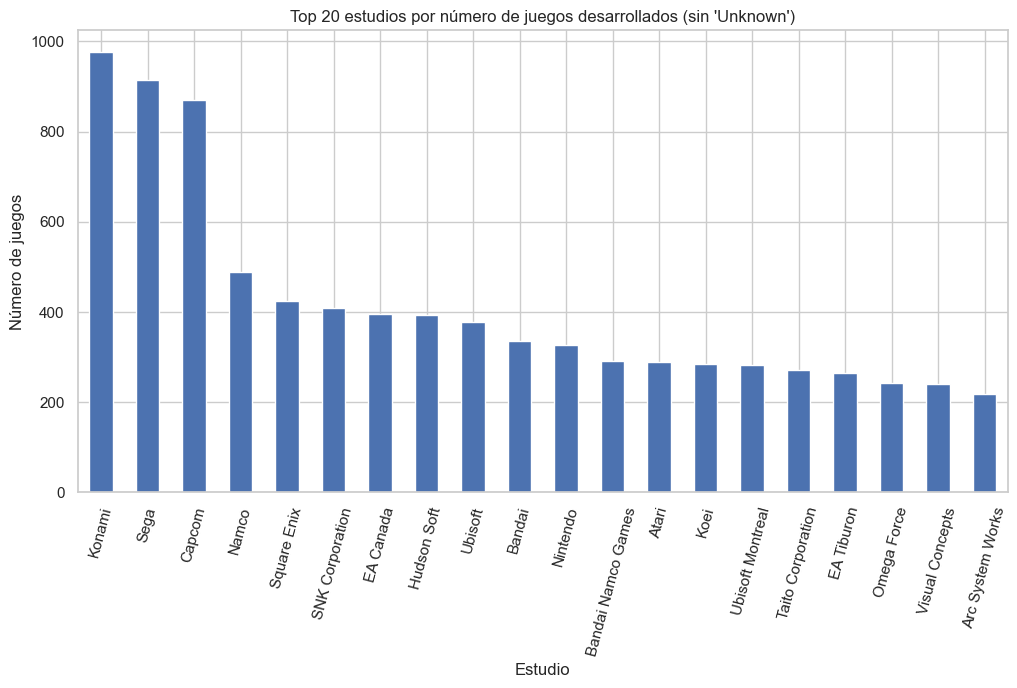

In [9]:
# Filtrar filas donde el developer no sea "Unknown"
df_dev_known = df[df["developer"] != "Unknown"].copy()

# Contar número de juegos por estudio (solo estudios conocidos)
juegos_por_dev = (
    df_dev_known.groupby("developer")["title"]
                .count()
                .sort_values(ascending=False)
                .head(20)
)

plt.figure(figsize=(12,6))
juegos_por_dev.plot(kind="bar")
plt.title("Top 20 estudios por número de juegos desarrollados (sin 'Unknown')")
plt.xlabel("Estudio")
plt.ylabel("Número de juegos")
plt.xticks(rotation=75)
plt.show()



In [ ]:
### Vista 18: Juego más comprado de cada género

En esta vista se identifica, para cada género (`genre`), el videojuego con mayores ventas globales (`total_sales`).

La tabla muestra:
- Género.
- Título del juego.
- Consola.
- Ventas globales.

Este análisis permite detectar “representantes máximos” de cada género en términos de éxito comercial.


In [11]:
### Vista 19: juego mas comprado de cada genero
idx_max_por_genero = df.groupby("genre")["total_sales"].idxmax()

vista18_top_juego_por_genero = df.loc[idx_max_por_genero, ["genre", "title", "console", "total_sales"]]
vista18_top_juego_por_genero.sort_values("total_sales", ascending=False)


,genre,title,console,total_sales
0,Action,Grand Theft Auto V,PS3,20.32
4,Shooter,Call of Duty: Black Ops 3,PS4,15.09
7,Action-Adventure,Red Dead Redemption 2,PS4,13.94
15,Sports,FIFA 18,PS4,11.80
27,Role-Playing,The Elder Scrolls V: Skyrim,X360,8.88
34,Simulation,The Sims 3,PC,7.96
42,Racing,Need for Speed Underground,PS2,7.20
44,Music,Just Dance 4,Wii,6.89
54,Misc,Minecraft,PS4,6.33
61,Fighting,Tekken 2,PS,5.74


In [ ]:
### Vista 20: Top juego por consola

En esta vista se determina, para cada consola (`console`), cuál es el videojuego con mayor valor en `total_sales`.

La tabla resultante incluye:
- Consola.
- Título del juego.
- Género.
- Ventas globales.

Esta información permite ver qué juego ha sido el más exitoso en cada plataforma.


In [16]:
# Quitamos filas sin total_sales, porque no sirven para elegir "más vendido"
df_valid_sales = df.dropna(subset=["total_sales"]).copy()

# Ordenamos por ventas globales de mayor a menor
df_ordenado = df_valid_sales.sort_values("total_sales", ascending=False)

# Para cada consola, nos quedamos con la primera fila (la de más ventas)
vista19_top_juego_por_consola = (
    df_ordenado
    .drop_duplicates(subset="console", keep="first")
    [["console", "title", "genre", "total_sales"]]
    .sort_values("total_sales", ascending=False)
)

vista19_top_juego_por_consola



,console,title,genre,total_sales
0,PS3,Grand Theft Auto V,action,20.33
1,PS4,Grand Theft Auto V,action,19.39
2,PS2,Grand Theft Auto: Vice City,action,16.15
3,X360,Grand Theft Auto V,action,15.87
28,XONE,Grand Theft Auto V,action,8.72
34,PC,The Sims 3,simulation,7.97
35,PSP,Grand Theft Auto: Liberty City Stories,action,7.71
44,WII,Just Dance 4,music,6.88
56,PS,Driver,action,6.26
63,DS,Cooking Mama,simulation,5.66


In [ ]:
### Vista 21: Que juego fue el ultimo actualizado de cada consola

In [ ]:
### Vista 22: Estudio mas presente en cada consola por videjouegos publicados

In [ ]:
### Vista 23: Que % compra cada zona de ventas por año?

In [ ]:
### Vista 24: Dispersión con regresión – `na_sales` vs `total_sales`

Esta visualización muestra un diagrama de dispersión (scatterplot) entre las ventas en Norteamérica (`na_sales`) y las ventas globales (`total_sales`), junto con una línea de regresión ajustada.

El objetivo es:
- Analizar la relación entre el rendimiento de un juego en Norteamérica y su éxito global.
- Observar si las ventas en esta región son un buen indicador del comportamiento mundial.
- Detectar posibles patrones o casos atípicos (juegos que venden mucho fuera de Norteamérica, por ejemplo).

La línea de regresión permite ver si la relación es aproximadamente lineal y si existe una tendencia clara:  
a mayor `na_sales`, mayor `total_sales`.  
Este tipo de gráfico es una primera aproximación a posibles modelos predictivos.


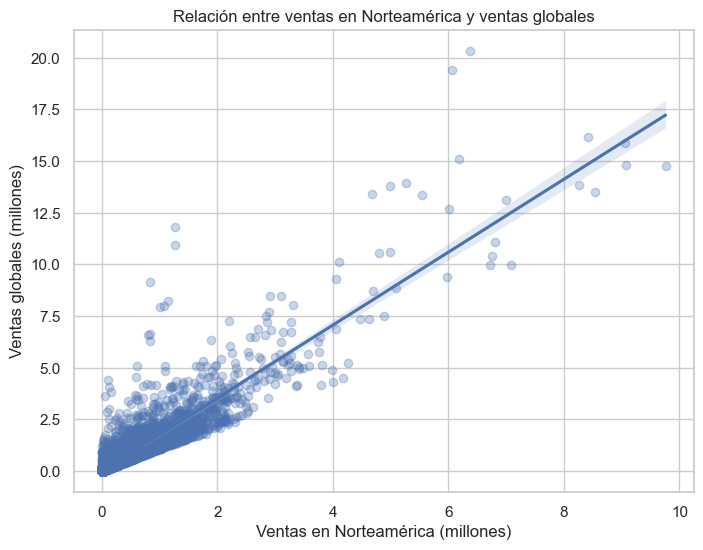


Interpretación:
- Existe relación positiva: cuanto más vende un juego en Norteamérica,
  más probable es que tenga buenas ventas globales.
- No obstante, hay títulos que destacan más en otras regiones.



In [10]:
plt.figure(figsize=(8,6))
sns.regplot(x=df["na_sales"], y=df["total_sales"], scatter_kws={"alpha":0.3})
plt.title("Relación entre ventas en Norteamérica y ventas globales")
plt.xlabel("Ventas en Norteamérica (millones)")
plt.ylabel("Ventas globales (millones)")
plt.show()

print("""
Interpretación:
- Existe relación positiva: cuanto más vende un juego en Norteamérica,
  más probable es que tenga buenas ventas globales.
- No obstante, hay títulos que destacan más en otras regiones.
""")
